In [1]:
%matplotlib inline
import sys
sys.path.append('../code')

from plotutils import *

In [2]:
"""
Parameters and settings used to generate TAP dynamics
"""

# noise_seed = 1010
# np.random.noise_seed = noise_seed
# torch.manual_seed(noise_seed)

Ns = 20    # No. of variables
Nr = 50   # No. of neurons
Ny = 22  

# Noise covariances 
q_process = 1e-5
q_obs     = 0.1
Q_process = q_process*np.eye(Ns)    # process noise
Q_obs     = q_obs*np.eye(Nr)        # use zero noise in train inputs to RNN

# Filter used for smoothing the input signals
smoothing_filter = signal.hamming(5,sym=True) 
smoothing_filter = smoothing_filter/sum(smoothing_filter)

# Coupling matrix settings
self_coupling_on, sparsity_J, Jtype  = 1, 0, 'nonferr' 

params = {'Ns':Ns,'Ny':Ny,'Nr':Nr,'Q_process':Q_process,'Q_obs':Q_obs,'nltype':'sigmoid','gain_y':25/np.sqrt(Ns),'smoothing_filter':smoothing_filter,'self_coupling_on':self_coupling_on,'sparsity_J':sparsity_J,'Jtype':Jtype  }

"""
ground truth TAP model parameters
"""

lam = np.array([0.25])  # low pass filtering constant for the TAP dynamics
G   = np.array([0,2,0,0,0,0,0,0,0,0,4,-4,0,-8,8,0,0,0]) # message passing parameters of the TAP equation
J   = 2*Create_J(Ns, sparsity_J, Jtype, self_coupling_on) # Coupling matrix 
U   = 3*np.random.rand(Nr,Ns) # embedding matrix

if Ns <= Ny:
    V = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[2]
else:
    V = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[0]

# concatenate the parameters
theta = np.concatenate([lam, G, JMatToVec(J), U.flatten('F'), V.flatten('F') ])


In [3]:
"""
Generate measurements. This will first be used for initial estimate of embedding using ICA
"""

B, T, T_clip  = 500, 50, 0 
T_low, T_high = 2, 5

params['gain_y'] = 50/np.sqrt(Ns)

x, y = generate_trainingdata_numpy(theta, params, B, T, T_clip, T_low, T_high)[0:2]

r = []
for b in range(B):
    r.append(np.dot(U,x[:,1:,b]))
    
r = np.array(r).transpose(1,2,0)

# Add independent noise to neural activity
r_brain   = r + np.sqrt(q_obs)*np.random.randn(r.shape[0], T, B)

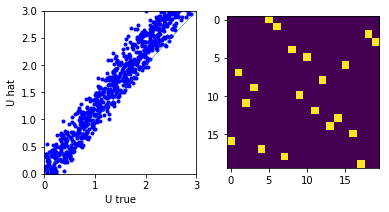

In [4]:
"""
Use ICA to get initial estimate of the embedding
"""
## filter measurements before applying ICA
# r_ = signal.filtfilt(smoothing_filter,1,r_brain,axis=1)
# U_hat = UhatICA(np.reshape(r_,[Nr,T*B],order='F').T, Ns)[0]
# del r_

U_hat = UhatICA(np.reshape(r_brain,[Nr,T*B],order='F').T, Ns)[0]

# Estimate the permutation matrix P (need this to resolve permutation ambiguity of ICA)
PermMat = EstimatePermutation_ICA(U,U_hat)


"""
Initialize the rest of the parameters
"""
G_hat    = np.zeros([18])
J_hat    = Create_J(Ns, params['sparsity_J'], params['Jtype'], params['self_coupling_on']) 
if Ns <= Ny:
    V_hat = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[2]
else:
    V_hat = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[0]

G_init   = np.copy(G_hat)
J_init   = np.copy(J_hat)
U_init   = np.copy(U_hat)
V_init   = np.copy(V_hat)
PermMat_init = np.copy(PermMat)

# Plot estimate of embedding and permutation matrix
umax = np.ceil(np.max(U))
umin = np.floor(np.min(U))

fig, ax = plt.subplots(1,2,figsize=(6,3))
ax[0].plot(U.flatten(),np.dot(U_hat,PermMat).flatten(),'b.')
ax[0].plot([umin,umax],[umin,umax],Linewidth=0.5)
ax[0].axis([umin,umax,umin,umax])
ax[0].set(xlabel='U true', ylabel='U hat')
ax[1].imshow(PermMat)
plt.show()

In [5]:
"""
Select only subset of data or generate new data
"""
T = 50
B = 20

## ------- pick a subset ------------------
# r_brain = r_brain[:,0:T,0:B].transpose(2,0,1)
# x       = x[:,0:T+1,0:B]
# y       = y[:,0:T,0:B].transpose(2,0,1)

# ------- generate new data ------------------
gain_yvec = np.linspace(1,50,B)/np.sqrt(Ns)

x, y, r = [], [], []

for b in range(B):
    params['gain_y'] = gain_yvec[b]
    x_b, y_b = generate_trainingdata_numpy(theta, params, 1, T, T_clip, T_low, T_high)[0:2]
    x.append(x_b[...,0])
    y.append(y_b[...,0])
    r.append(np.dot(U,x_b[:,1:,0]))
    
x = np.array(x).transpose(1,2,0)
y = np.array(y).transpose(1,2,0)
r = np.array(r).transpose(1,2,0)

del x_b, y_b


# Add independent noise to neural activity
r_brain   = r + np.sqrt(q_obs)*np.random.randn(r.shape[0], T, B)

# Reshape the neural activity and measurements into batches x no. of vars x time
r_brain = r_brain.transpose(2,0,1)
y       = y.transpose(2,0,1)


In [6]:
"""
Convert data to torch tensors
"""

device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype     = torch.float64

Q_process = torch.tensor(Q_process,device=device,dtype=dtype)
Q_obs     = torch.tensor(Q_obs,device=device,dtype=dtype)

P_process = Q_process.inverse()
P_obs     = Q_obs.inverse()

r_brain   = torch.tensor(r_brain,device=device,dtype=dtype)
y         = torch.tensor(y,device=device,dtype=dtype)

lam       = torch.tensor(lam,device=device,dtype=dtype,requires_grad=False)

G      = torch.tensor(G,device=device,dtype=dtype,requires_grad=False)
J      = torch.tensor(J,device=device,dtype=dtype,requires_grad=False)
U      = torch.tensor(U,device=device,dtype=dtype,requires_grad=False)
V      = torch.tensor(V,device=device,dtype=dtype,requires_grad=False)

G_hat  = torch.tensor(G_hat,device=device,dtype=dtype,requires_grad=True)
J_hat  = torch.tensor(J_hat,device=device,dtype=dtype,requires_grad=True)
U_hat  = torch.tensor(U_hat,device=device,dtype=dtype,requires_grad=True)
V_hat  = torch.tensor(V_hat,device=device,dtype=dtype,requires_grad=True)

In [7]:
"""
Run PF with true values of parameters
"""
 
Np = 100 # No. of particles to use

with torch.no_grad():
    LL_tp, x_tp, P_tp, W_tp = particlefilter_torch(G, J, U, V, lam, r_brain, y, P_process, P_obs, Np)


r_tp = torch.matmul(U,x_tp[...,1:])
    
"""
Run PF with initial values of parameters
"""
t_st = time.time()
with torch.no_grad():
    LL_hat, x_hat, P_hat, W_hat = particlefilter_torch(G_hat, J_hat, U_hat, V_hat, lam, r_brain, y, P_process, P_obs, Np)


t_en = time.time()
print('time elapsed =',np.round(1000*(t_en - t_st))/1000, 's')
print('Likelihood with true parameters =', LL_tp.mean().data.numpy())
print('Likelihood with initial parameters =', LL_hat.mean().data.numpy())

x_init = x_hat*1.0
r_init = torch.matmul(U_hat,x_hat[...,1:])

time elapsed = 2.506 s
Likelihood with true parameters = -1476.6109397730083
Likelihood with initial parameters = -83548.82909941395


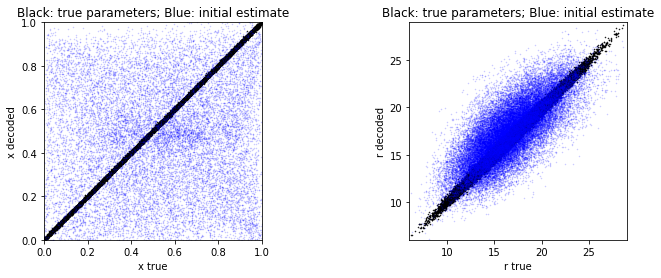

In [8]:
"""
Plot comparison of latent states decoded by the PF using initial value of parameters vs. ground truth
"""

T_st = 10 # discard the first T_st samples for plotting
B    = x.shape[2]

fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(x[:,T_st:,:].flatten(), x_tp[...,T_st:].permute(1,2,0).data.numpy().flatten(),'k.',markersize=1)
ax[0].plot(x[:,T_st:,:].flatten(), np.dot(PermMat.T, np.reshape(x_init[...,T_st:].permute(1,2,0).data.numpy(),[Ns,B*(T+1-T_st)])).flatten(),'b.',markersize=1,alpha=0.2)
ax[0].set(xlabel='x true', ylabel='x decoded')
ax[0].set_title('Black: true parameters; Blue: initial estimate')
ax[0].axis('square')
ax[0].axis([0,1,0,1])

rmax = np.round(r_brain.max().item())
rmin = np.round(r_brain.min().item())

ax[1].plot(r_brain[...,T_st:].data.numpy().flatten(),r_tp[...,T_st:].data.numpy().flatten(),'k.',markersize=1)
ax[1].plot(r_brain[...,T_st:].data.numpy().flatten(),r_init[...,T_st:].data.numpy().flatten(),'b.',markersize=1,alpha=0.2)
ax[1].set(xlabel='r true', ylabel='r decoded')
ax[1].set_title('Black: true parameters; Blue: initial estimate')
ax[1].axis('square')
ax[1].axis([rmin,rmax,rmin,rmax])
#plt.savefig('InitialDynamics.pdf')
plt.show()

In [9]:
# Run PF-EM

lrate      = 2e-2
opt_params = [G_hat,J_hat,U_hat, V_hat]
NEpochs    = 500
LLVec      = []
optimizer  = torch.optim.Adam(opt_params,lr=lrate, betas=(0.9, 0.999))

t_st = time.time()

for epoch in range(NEpochs):
    
    # zero-gradients at the start of each epoch
    optimizer.zero_grad() 
    
    # E-step
    C = Qfunction_torch(G_hat, J_hat, U_hat, V_hat, lam, r_brain[...,T_st:], y[...,T_st:], P_hat[...,T_st:], W_hat, P_process, P_obs)
    
    # M-step
    C.backward() 
    G_hat.grad[0], G_hat.grad[9] = 0, 0 # set gradient of G0 and G9 to zero
    optimizer.step()

    
    # Run PF again to get posterior for E-step
    with torch.no_grad():
        LL_hat, x_hat, P_hat, W_hat = particlefilter_torch(G_hat, J_hat, U_hat, V_hat, lam, r_brain, y, P_process, P_obs, Np)
        
    LLVec.append(LL_hat.mean())
    
    if (epoch+1) % 50 == 0:
        print('[%d] log likelihood: %.5f' %(epoch + 1, LL_hat.mean()))

t_en = time.time()

print('Finished training')
print('Time elapsed =', np.round(1000*(t_en - t_st))/1000, 's')

[50] log likelihood: -11120.13468
[100] log likelihood: -7322.53677
[150] log likelihood: -6290.66607
[200] log likelihood: -5887.49285
[250] log likelihood: -5480.21345
[300] log likelihood: -5251.25589
[350] log likelihood: -5145.50720
[400] log likelihood: -4987.10152
[450] log likelihood: -4993.17622
[500] log likelihood: -4785.80938
Finished training
Time elapsed = 1597.542 s


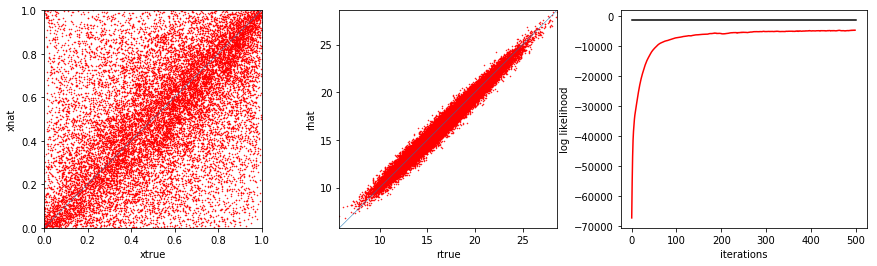

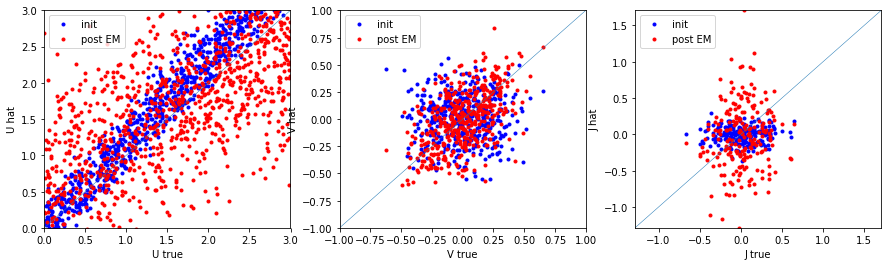

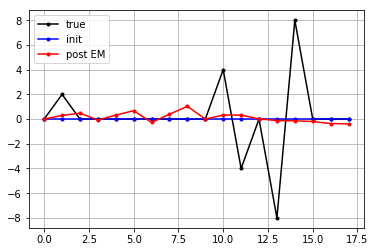

In [10]:
"""
Plotting results
"""

T_st = 10
B = x.shape[2]

G_hat_ = G_hat.detach().cpu().data.numpy()
J_hat_ = J_hat.detach().cpu().data.numpy()
U_hat_ = U_hat.detach().cpu().data.numpy()
V_hat_ = V_hat.detach().cpu().data.numpy()

# Estimate PermMat again
PermMat = EstimatePermutation_ICA(U.data.numpy(),U_hat_)

# fit to neural activity
r_hat = torch.matmul(U_hat,x_hat[...,1:])
r_hat_ = r_hat.data.numpy()
rmax  = r_brain.max().item()
rmin  = r_brain.min().item()

# figure 1
x_hat_ = x_hat.permute(1,2,0).data.numpy()
fig, ax = plt.subplots(1,3,figsize=(15,4))
ax[0].plot(x[:,T_st:,:].flatten(), np.dot(PermMat.T, np.reshape(x_hat_[:,T_st:],[Ns,B*(T+T_clip+1-T_st)])).flatten(),'r.',markersize=1)
ax[0].plot([0,1],[0,1],linewidth=0.5)
ax[0].set(xlabel='xtrue', ylabel='xhat')
ax[0].axis('square')
ax[0].axis([0,1,0,1])

ax[1].plot(r_brain[...,T_st:].data.numpy().flatten(),r_hat_[...,T_st:].flatten(),'r.',markersize=1)
ax[1].plot([rmin,rmax],[rmin,rmax],linewidth=0.5)
ax[1].set(xlabel='rtrue', ylabel='rhat')
ax[1].axis('square')
ax[1].axis([rmin,rmax,rmin,rmax])

ax[2].plot(torch.stack(LLVec).data.numpy(),'r')
ax[2].plot([0,len(LLVec)],LL_tp.mean().item()*np.ones([2]),'k')
ax[2].set(xlabel='iterations', ylabel='log likelihood')
#plt.savefig('Dynamics.pdf')
plt.show()

# Figure 2
Jmax = max(np.max(J.data.numpy()),np.max(J_hat_))
Jmin = min(np.min(J.data.numpy()),np.min(J_hat_))
Jhat = J_hat_*0
Jinit = J_init*0 # shuffle Jinit also
x_idx = np.dot(PermMat.T, np.arange(Ns))

for ii in range(Ns):
    for jj in range(Ns):
        Jhat[ii,jj] = J_hat_[np.int(x_idx[ii]),np.int(x_idx[jj])]
        Jinit[ii,jj] = J_init[np.int(x_idx[ii]),np.int(x_idx[jj])]
                          

fig, ax = plt.subplots(1,3,figsize=(15,4))
umax = U.max().item()
umin = U.min().item()

ax[0].plot(U.numpy().flatten(),np.dot(U_init,PermMat_init).flatten(),'b.')
ax[0].plot(U.numpy().flatten(),np.dot(U_hat_,PermMat).flatten(),'r.')

ax[0].plot([umin,umax],[umin,umax],Linewidth=0.5)
ax[0].axis([umin,umax,umin,umax])
ax[0].set(xlabel='U true', ylabel='U hat')
ax[0].legend(['init', 'post EM'])

ax[1].plot(V.numpy().flatten(),np.dot(PermMat.T, V_init).flatten(),'b.')
ax[1].plot(V.numpy().flatten(),np.dot(PermMat.T, V_hat_).flatten(),'r.')
ax[1].plot([-1,1],[-1,1],linewidth=0.5)
ax[1].axis([-1,1,-1,1])
ax[1].set(xlabel='V true', ylabel='V hat')
ax[1].legend(['init', 'post EM'])

ax[2].plot(JMatToVec_torch(J,device,dtype).numpy(),JMatToVec(Jinit),'b.')
ax[2].plot(JMatToVec_torch(J,device,dtype).numpy(),JMatToVec(Jhat),'r.')
ax[2].plot([Jmin,Jmax],[Jmin,Jmax],linewidth=0.5)
ax[2].axis([Jmin,Jmax,Jmin,Jmax])
ax[2].set(xlabel='J true', ylabel='J hat')
ax[2].legend(['init', 'post EM'])
#plt.savefig('Parameters.pdf')
plt.show()

# Plot G 
plt.plot(G.data.numpy(),'k.-')
plt.plot(G_init,'b.-')
plt.plot(G_hat_,'r.-')
plt.legend(['true','init','post EM'])
plt.grid(True)
#plt.savefig('G.pdf')
plt.show()

mean SNR =  46.38550228992817


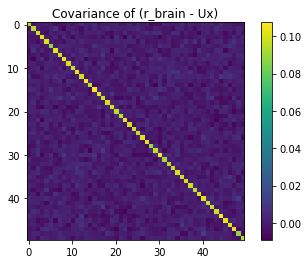

In [11]:
"""
SNR checks
"""
r_sig = torch.matmul(U,torch.tensor(x[:,1:],device=device,dtype=dtype).permute(2,0,1))
dr    = r_brain - r_sig
dr    = dr.permute(1,2,0).data.numpy()
r_sig = r_sig.permute(1,2,0).data.numpy()
C_sig = np.cov(np.reshape(r_sig,[Nr,B*T]))
C_err = np.cov(np.reshape(dr,[Nr,B*T]))
print('mean SNR = ', np.mean(np.diag(C_sig)/np.diag(C_err)))

plt.imshow(C_err)
plt.title('Covariance of (r_brain - Ux)')
plt.colorbar()
#plt.savefig('Rcovariance.pdf')
plt.show()

In [12]:
"""
Validate on new measurements
"""

B_val = 50
x_val, y_val  = generate_trainingdata_numpy(theta, params, B_val, T, T_clip, T_low, T_high)[0:2]

# Run TAP dynamics using inferred theta

theta_hat = np.concatenate([lam, G_hat_, JMatToVec(J_hat_), U_hat_.flatten('F'), V_hat_.flatten('F') ])

x_hat_val = np.zeros([Ns, T + T_clip + 1, B_val])

for bi in range(B_val):
    x_hat_val[...,bi] = runTAP(np.random.rand(Ns), y_val[...,bi], Q_process.data.numpy(), Q_obs.data.numpy(), theta_hat, params['nltype'])[0]


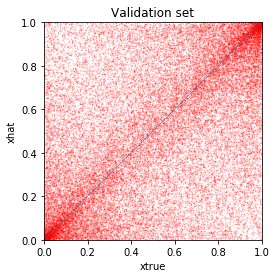

In [13]:
"""
Plot results on validation set
"""

T_st = 10
plt.plot(x_val[:,T_st:,:].flatten(), np.dot(PermMat.T, np.reshape(x_hat_val[:,T_st:],[Ns,B_val*(T+T_clip+1-T_st)])).flatten(),'r.',markersize=1,alpha=0.2)
plt.plot([0,1],[0,1],linewidth=0.5)
plt.xlabel('xtrue')
plt.ylabel('xhat')
plt.title('Validation set')
plt.axis('square')
plt.axis([0,1,0,1])
#plt.savefig('Xvalidation.pdf')
plt.show()

MSE for x =  0.1015599988025249


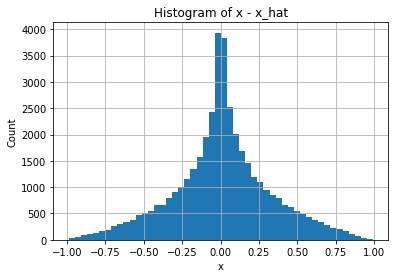

In [14]:
x_hat_val_ = np.copy(x_hat_val)
for b in range(B_val):
    x_hat_val_[...,b] = np.dot(PermMat.T,x_hat_val[...,b])
    
print('MSE for x = ', np.mean((x_val - x_hat_val_)**2))

T_st = 10
plt.grid(True)
plt.hist((x_val[:,T_st:] - x_hat_val_[:,T_st:]).flatten(),50)
plt.title('Histogram of x - x_hat'); plt.xlabel('x'); plt.ylabel('Count')
# plt.axis([-0.5,0.5,0,20000])
#plt.savefig('ErrorHistogramValidation.pdf')
plt.show()